Authors:

Marc Lagoin /
Pierre-Louis Delcroix

# Objectif

Dans ce projet, nous réalisons une catégorisation de pixels basée sur des images hyperspectrales et LiDAR afin de déterminer à quelles classes d'objets (1 à 15) ils correspondent.

Notre première étape consistera à prétraiter les images hyperspectrales et LiDAR. Nous appliquerons une technique visant à normaliser les données. Par la suite, nous évaluerons différents modèles de classification et sélectionnerons le plus performant. Enfin, nous appliquerons le modèle choisi pour prédire les classes d'objets dans les images.

# Import des bibliothèques

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
import random
from sklearn.metrics import accuracy_score

# Chargement des données

In [2]:
data = sp.io.loadmat('data/2013_DFC_contest.mat')

In [3]:
lidar = data['lidar']
print("L'image LiDAR est composée de %d lignes et %d colonnes "%(lidar.shape)+"au format %s"%lidar.dtype)

L'image LiDAR est composée de 349 lignes et 1905 colonnes au format float32


In [4]:
hsi_raw = data['hyper']
print("L'image hyperspectrale est composée de %d lignes, %d colonnes et %d bandes "%(hsi_raw.shape)
      +"au format %s"%hsi_raw.dtype)

L'image hyperspectrale est composée de 349 lignes, 1905 colonnes et 144 bandes au format uint16


In [5]:
rgb_bands = [54,32,18]
hsi_rgb = hsi_raw[:,:,rgb_bands]
hsi_rgb = hsi_rgb/hsi_rgb.max() # normalisation des valeurs dans [0,1] pour l'affichage

In [6]:
groundtruth = np.load('groundtruth/groundtruth.npy')
groundtruth_info = np.load('groundtruth/groundtruth_info.npy',allow_pickle=True)
groundtruth_rgb = plt.imread('groundtruth/groundtruth.png')

# Visualisation des données

Channel:  92


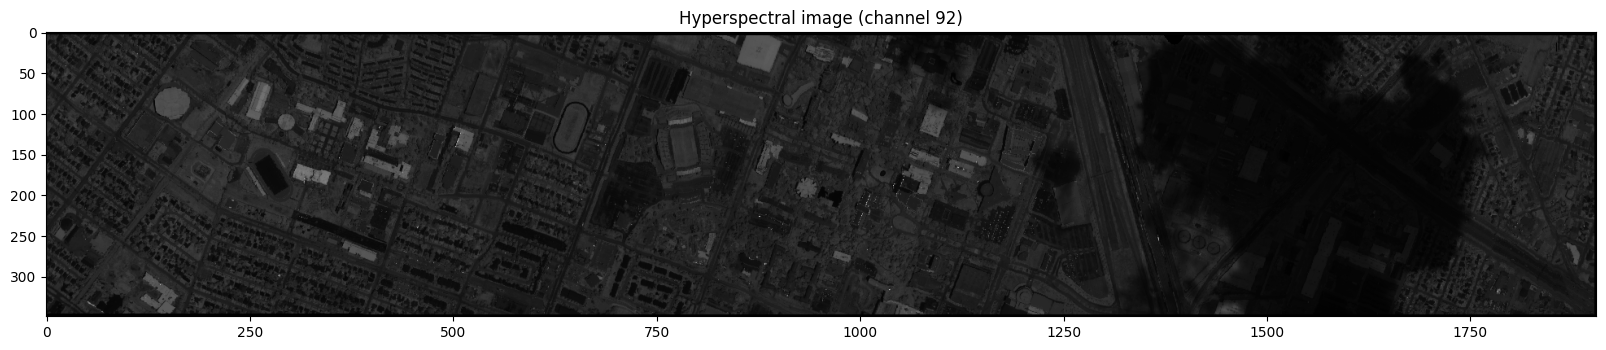

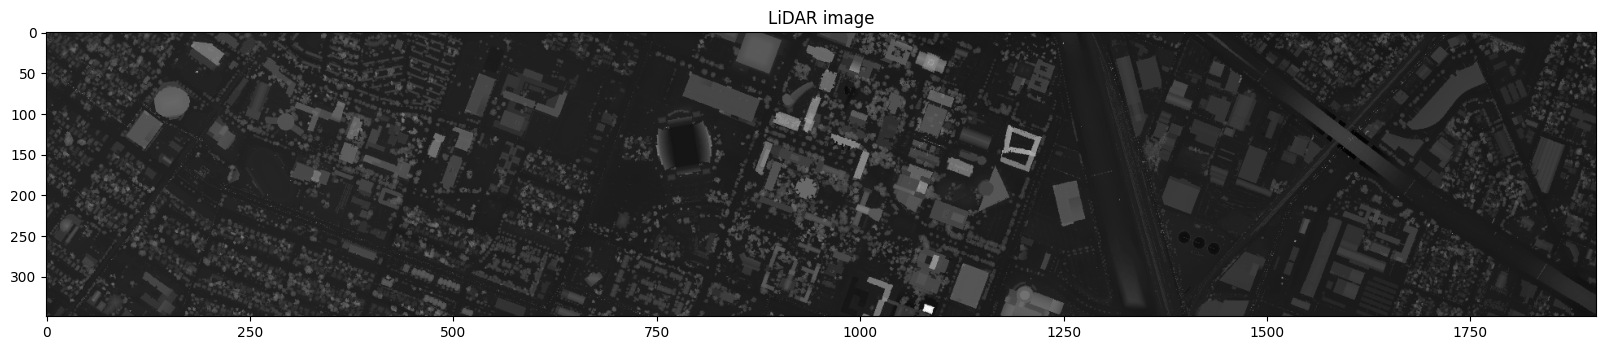

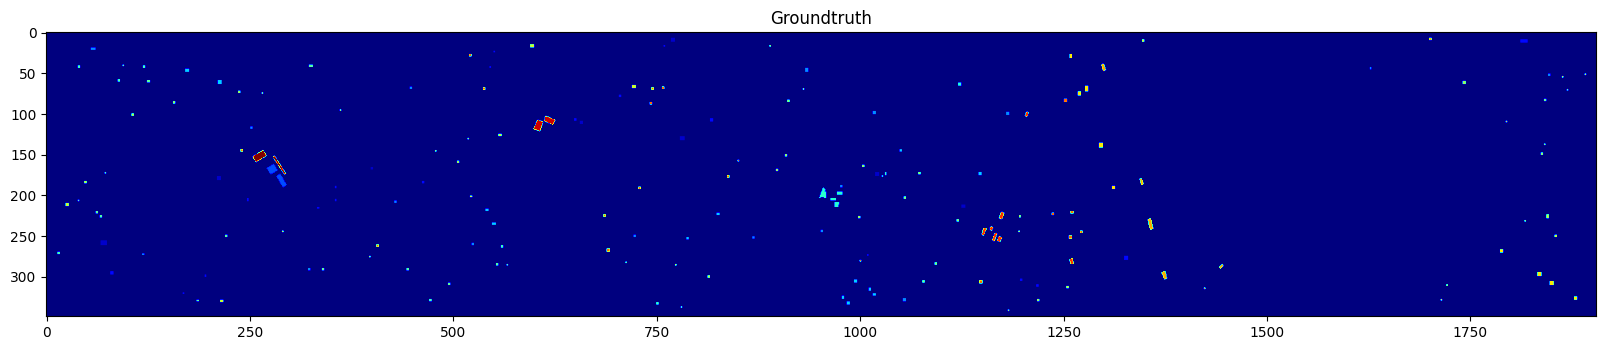

In [7]:
channel = random.randint(0, 144)
print("Channel: ", channel)

plt.figure(figsize=(20,5))
plt.imshow(hsi_raw[:, :, channel], cmap='gray')
plt.title("Hyperspectral image (channel {})".format(channel))
plt.show()

plt.figure(figsize=(20,5))

plt.imshow(lidar, cmap='gray')
plt.title("LiDAR image")
plt.show()

plt.figure(figsize=(20,5))
plt.title('Groundtruth')
plt.imshow(groundtruth, cmap='jet')
plt.show()

# Définition des fonctions

In [8]:
def format_data(groundtruth, hyper):
    mask = groundtruth > 0
    X = hyper[mask]
    y = groundtruth[mask]
    
    return X, y

In [9]:
def reshape_data(hyper):
    r, c, N = hyper.shape
    hi = hyper.reshape(r*c, N)

    return hi, r, c

In [10]:
def save_prediction(prediction):
    filename_predictions = "predictions.npz"
    print("Saving predictions to %s"%filename_predictions)
    np.savez_compressed(filename_predictions, data=prediction)
    print("Done")

def predictPCA_and_display(classifier, hyper, title, groundtruth_info, pca):
    hi, r, c = reshape_data(hyper)
    hi_pca = pca.transform(hi)
    res = classifier.predict(hi_pca)
    res = res.reshape(r, c)

    color_map = {}
    for class_info in groundtruth_info:
        class_id = class_info["class_label"]
        color_map[class_id] = class_info["class_color"].tolist()

    img = np.zeros((res.shape[0], res.shape[1], 3), dtype=np.uint8)
    for class_id, color in color_map.items():
        img[res == class_id] = color


    plt.figure(figsize=(20,5))
    plt.imshow(img, interpolation_stage="rgba")
    plt.axis("off")
    plt.title(title)
    plt.show()
    
def load_prediction():
    filename_predictions = "predictions.npz"
    prediction = np.load(filename_predictions)

    return prediction

In [11]:
def normalize_data(data):
    return (data - data.min()) / (data.max() - data.min())

In [12]:
def predict_and_display(classifier, hyper, title):
    hi, r, c = reshape_data(hyper)

    res = classifier.predict(hi)
    res = res.reshape(r, c)

    plt.figure(figsize=(20,5))
    plt.title(title)
    plt.imshow(res, cmap='jet')
    plt.show()

# Prétraitement

### Normalisation des images

In [13]:
hsi_normalized = normalize_data(hsi_raw)
lidar_normalized = normalize_data(lidar) 

### Fusion des images

In [14]:
lidar_expanded = np.expand_dims(lidar_normalized, axis=-1)
fused = np.concatenate((hsi_normalized, lidar_expanded), axis=-1)

# Séparation des données en ensembles d'entraînement et de test

In [15]:
X, y = format_data(groundtruth, fused)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modélisation

### Random Forest

In [16]:
rf_clf = RandomForestClassifier(max_depth=15, random_state=42)
rf_clf.fit(X_train, y_train)
rf_score = rf_clf.score(X_test, y_test)

print("La précision du Random Forest est de " + str(rf_score))

La précision du Random Forest est de 0.9047619047619048


In [17]:
predict_and_display(rf_clf, fused, "Random Forest Classifier")

### Linear SVC

In [ ]:
svc_clf = LinearSVC(random_state=42)
svc_clf.fit(X_train, y_train)
svc_score = svc_clf.score(X_test, y_test)
print("La précision du Linear SVC est de " + str(svc_score))

In [ ]:
predict_and_display(svc_clf, fused, "Linear SVC Classifier")

## Interpretation des résultats

Les résultats obtenus avec les deux classificateurs, Random Forest et Linear SVC, montrent une différence notable dans leur performance pour la classification sémantique des pixels. Le classificateur Random Forest a obtenu un score élevé d'environ 0.90, indiquant une capacité à bien distinguer les différentes classes de pixels, et reflétant ainsi une bonne adéquation entre les données et le modèle utilisé.

En revanche, le classificateur Linear SVC a obtenu un score plus faible d'environ 0.69, ce qui suggère que ce modèle ne capture pas aussi efficacement les caractéristiques distinctives des classes de pixels. Cela pourrait être dû à la nature linéaire du modèle Linear SVC, qui peut ne pas être en mesure de séparer correctement les classes si les relations entre les caractéristiques et les classes sont plus complexes et non linéaires.

Dans ce contexte, le classificateur Random Forest semble être un choix plus approprié pour la tâche de classification sémantique des pixels à partir des images hyperspectrales et LiDAR fusionnées. La structure flexible et non linéaire des arbres de décision utilisés dans le modèle Random Forest peut mieux capturer les relations complexes entre les données fusionnées et les classes de pixels.

# Réduction de dimension

### PCA

In [ ]:
pca = PCA(n_components=15)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
rf_clf_pca = RandomForestClassifier(max_depth=15, random_state=42)
rf_clf_pca.fit(X_train_pca, y_train)
rf_pca_score = rf_clf_pca.score(X_test_pca, y_test)
print(rf_pca_score)
predictPCA_and_display(rf_clf_pca, fused, "Random Forest Classifier", groundtruth_info, pca)

In [ ]:
svc_clf_pca = LinearSVC(random_state=42)
svc_clf_pca.fit(X_train_pca, y_train)
svc_score_pca = svc_clf_pca.score(X_test_pca, y_test)
print(svc_score_pca)
predictPCA_and_display(svc_clf_pca, fused, "Linear SVC", groundtruth_info, pca)

### Interprétation des résultats du PCA

 Les scores obtenus après cette étape indiquent que le RF a performé de manière significativement meilleure avec un score de 0.95 comparé à celui du Linear SVC qui est à 0.69.

L'interprétation de ces résultats peut être que le RF est capable de mieux exploiter les informations contenues dans les composantes principales extraites par la PCA. Le RF, étant un modèle non linéaire, peut capter les relations complexes entre les composantes principales, ce qui lui permet de mieux séparer les différentes classes de pixels.

En revanche, le Linear SVC, étant un modèle linéaire, pourrait ne pas être en mesure de capter ces relations complexes dans les données transformées par la PCA, d'où sa performance inférieure. Cela pourrait suggérer que la séparation des classes dans l'espace des composantes principales n'est pas purement linéaire, et donc un modèle non linéaire comme le RF est plus approprié.

Le RF semble être un meilleur choix pour ce problème de classification de pixels à partir des données transformées par la PCA.

In [ ]:
hi, r, c = reshape_data(fused)
hi_pca = pca.transform(hi)
predictions = rf_clf_pca.predict(hi_pca)
predictions = predictions.reshape(groundtruth.shape)

# Export des données

In [ ]:
assert predictions.shape == groundtruth.shape
assert(np.all(np.in1d(predictions.flatten(), np.unique(groundtruth))))

In [ ]:
save_prediction(predictions)

In [ ]:
loaded_data = np.load('predictions.npz')['data']
assert(np.allclose(loaded_data, predictions))

In [ ]:
def submission(hs_raw, lidar, model):
    # Normalize the data
    hs_norm = normalize_data(hs_raw)
    lidar_norm = normalize_data(lidar)

    # Fuse the data
    lidar_expanded = np.expand_dims(lidar_norm, axis=-1)
    fused = np.concatenate((hs_norm, lidar_expanded), axis=-1)

    pca = PCA(n_components=15)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    rf_clf_pca = RandomForestClassifier(max_depth=15, random_state=42)
    rf_clf_pca.fit(X_train_pca, y_train)
    
    # Reshape and save
    hi, r, c = reshape_data(fused)
    hi_pca = pca.transform(hi)
    predictions = rf_clf_pca.predict(hi_pca)
    predictions = predictions.reshape(groundtruth.shape)    
    # save
    save_prediction(predictions)

In [ ]:
submission(hsi_raw, lidar, rf_clf)

# Conclusion

### Répartitions des tâches

Un premier membre du groupe s'est concentré sur le prétraitement des données. Cela comprenait le chargement et l'exploration des données, la réalisation de l'analyse exploratoire des données pour comprendre les caractéristiques clés et les tendances dans les images hyperspectrales et LiDAR. Il a ensuite procédé à la normalisation et à la fusion des données, assurant ainsi que les images hyperspectrales et LiDAR étaient correctement alignées et prêtes pour la modélisation.

D'autre part, le deuxième membre s'est chargé de la modélisation. Cela a commencé par la séparation des données en ensembles d'entraînement et de test pour assurer une évaluation juste et robuste du modèle. Le deuxième membre a ensuite choisi et entraîné le modèle de classification, en l'occurrence un Random Forest et un Linear SVC, sur l'ensemble d'entraînement. Enfin, il a évalué les performances du modèle sur l'ensemble de test, en utilisant des métriques appropriées pour quantifier l'exactitude de la classification.

### Pistes d'amélioration

- Essayer d'autres techniques de prétraitement : Bien que la normalisation soit une technique couramment utilisée, d'autres méthodes de prétraitement pourraient aider à améliorer les performances du modèle, comme la standardisation, la discrétisation, ou l'utilisation de techniques plus avancées comme la normalisation par lots ou la normalisation par instance.

- Utiliser des modèles plus sophistiqués : Nous avons utilisé des modèles de classification de base tels que le Random Forest et le Linear SVC. Des modèles plus sophistiqués, comme les réseaux de neurones convolutionnels (CNN), pourraient être capables de capturer des relations plus complexes dans les données.

- Utiliser des techniques d'augmentation de données : Cela pourrait aider à créer un modèle plus robuste en ajoutant de la diversité à l'ensemble d'entraînement.

- Fusion de modèles : Plutôt que de se fier à un seul modèle, on pourrait explorer des techniques d'ensemble pour combiner les prédictions de plusieurs modèles.